# Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

In [4]:
import re

In [5]:
import nltk

In [6]:
import pickle

In [7]:
import string

In [8]:
import numpy as np

In [9]:
from keras.utils.np_utils import to_categorical

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, accuracy_score, plot_confusion_matrix

In [11]:
from google.colab import files

# Data Reading

In [12]:
#since we're using google colab to run the files, we can import the data after an upload
# uploaded = files.upload()

In [13]:
df = pd.read_csv('us_election_2020_1st_presidential_debate.csv').drop('minute', axis=1)

# Test processing & Cleaning

In [14]:
def read_clean(text):
    '''
    Makes text lowercase, without punctuations, numbers removed and both numbers with letters next to it too.
    Input: 
        text: string type
    Output:
        text: a transformed string in lowercase, without punctuations etc.
    '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation),'', text)
    text = re.sub('w*\d\w', '', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [15]:
df['text'] = df['text'].apply(read_clean)
df['speaker'].unique()

array(['Chris Wallace', 'Vice President Joe Biden',
       'President Donald J. Trump', 'Chris Wallace:'], dtype=object)

# Target Counts

In [16]:
df['speaker'] = df['speaker'].apply(lambda x: x.replace(':', ''))

In [17]:
instances = df['speaker'].value_counts()
instances

President Donald J. Trump    314
Vice President Joe Biden     249
Chris Wallace                226
Name: speaker, dtype: int64

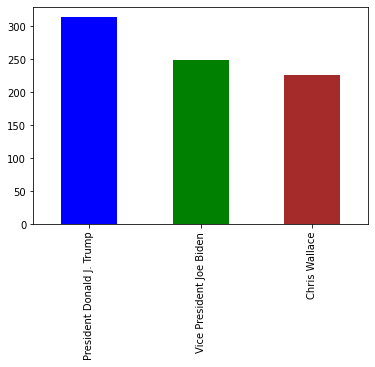

In [18]:
#visualize the speakers using a bar graph
instances.plot(kind='bar', color=['blue','green','brown']);

# Bench-Mark Model.

## 1.1 Create the predictor variable Y

This will be the first instance of the model. Here, we just use the original Data as it is withoug perfoming any sampling techniques. 

In [19]:
unique_speakers = list(df['speaker'].unique())

In [20]:
y = to_categorical(df['speaker'].apply(lambda x: unique_speakers.index(x)))

## 1.2 Split to test train Split

In [21]:
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.1)

## 1.3 Feature Engineering

 Using TfidfVectorizer

In [22]:
tf = TfidfVectorizer(min_df=0.01,stop_words='english').fit(train_x)
train_x = tf.transform(train_x).toarray()
test_x = tf.transform(test_x).toarray()
    

## 1.5 Model Creation

In [23]:
train_x.shape

(710, 140)

Lets start by defining a Keras Helper model that will be used to do the Model Building.

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization

def keras_model():
    model = Sequential()
    model.add(Dense(30, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

In [25]:
model = keras_model()
model.fit(train_x, train_y, batch_size=1, epochs=5, validation_split=0.1)

Epoch 1/5
639/639 [==============================] - 1s 832us/step - loss: 1.0762 - accuracy: 0.4241 - val_loss: 1.0342 - val_accuracy: 0.5493
Epoch 2/5
639/639 [==============================] - 0s 679us/step - loss: 0.9272 - accuracy: 0.5540 - val_loss: 0.8166 - val_accuracy: 0.5915
Epoch 3/5
639/639 [==============================] - 0s 676us/step - loss: 0.8044 - accuracy: 0.6448 - val_loss: 0.7523 - val_accuracy: 0.6901
Epoch 4/5
639/639 [==============================] - 0s 677us/step - loss: 0.7110 - accuracy: 0.6776 - val_loss: 0.7583 - val_accuracy: 0.6479
Epoch 5/5
639/639 [==============================] - 0s 663us/step - loss: 0.6607 - accuracy: 0.7074 - val_loss: 0.7103 - val_accuracy: 0.7042


In [26]:
preds = model.predict(test_x).argmax(axis=1)
preds

array([2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2,
       2, 2, 0, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0,
       1, 2, 0, 2, 2, 0, 0, 0, 1, 1, 2, 2, 0])

In [27]:
accuracy_score(test_y.argmax(axis=1), preds)

0.7215189873417721

In [28]:
f1_score(test_y.argmax(axis=1), preds, average='micro')

0.7215189873417721

In [29]:
cm = pd.DataFrame(confusion_matrix(test_y.argmax(axis=1), preds), columns = unique_speakers, index= unique_speakers)
cm.columns.name = "Predicted"
cm.index.name = "Actual"

In [30]:
cm

Predicted,Chris Wallace,Vice President Joe Biden,President Donald J. Trump
Actual,,,
Chris Wallace,16,0,6
Vice President Joe Biden,3,12,10
President Donald J. Trump,1,2,29


# Down-Sampled Model



## 1.1 Downsample the model manually

In [31]:
cleaned_dfs = []

for val in df['speaker'].unique():
    cleaned_dfs.append(df[df['speaker']==val].sample(226))

sampled_df = pd.concat(cleaned_dfs).reset_index(drop=True)

## 1.2 Create the predictor variable Y

In [32]:
sampled_df['speaker'].value_counts()

President Donald J. Trump    226
Vice President Joe Biden     226
Chris Wallace                226
Name: speaker, dtype: int64

In [33]:
unique_speakers = list(sampled_df['speaker'].unique())

In [34]:
y = to_categorical(sampled_df['speaker'].apply(lambda x : unique_speakers.index(x)))

## 1.3 Train Test Split

In [35]:
train_x, test_x, train_y, test_y = train_test_split(sampled_df['text'], y, test_size=0.1)

## 1.4 Feature Engineering

Using TfidfVectorizer

In [36]:
tf = TfidfVectorizer(min_df=0.01, stop_words='english').fit(train_x)
train_x = tf.transform(train_x).toarray()
test_x = tf.transform(test_x).toarray()

## 1.5 Model Creation

#### Using data from tfidf

In [37]:
train_x.shape

(610, 159)

In [38]:
model = keras_model()
model.fit(train_x, train_y, batch_size=1, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
549/549 [==============================] - 0s 826us/step - loss: 1.0857 - accuracy: 0.3971 - val_loss: 1.0236 - val_accuracy: 0.5410
Epoch 2/5
549/549 [==============================] - 0s 680us/step - loss: 0.9610 - accuracy: 0.5774 - val_loss: 0.8084 - val_accuracy: 0.6557
Epoch 3/5
549/549 [==============================] - 0s 691us/step - loss: 0.8072 - accuracy: 0.6339 - val_loss: 0.6817 - val_accuracy: 0.6885
Epoch 4/5
549/549 [==============================] - 0s 700us/step - loss: 0.7075 - accuracy: 0.7031 - val_loss: 0.6355 - val_accuracy: 0.7377
Epoch 5/5
549/549 [==============================] - 0s 738us/step - loss: 0.6430 - accuracy: 0.7122 - val_loss: 0.5950 - val_accuracy: 0.7377


In [39]:
preds = model.predict(test_x).argmax(axis=1)

In [40]:
preds

array([2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0,
       1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 2,
       2, 1])

# Test Scores

In [41]:
accuracy_score(test_y.argmax(axis=1), preds)

0.7205882352941176

In [42]:
f1_score(test_y.argmax(axis=1), preds, average='micro')

0.7205882352941176

In [43]:
cm = pd.DataFrame(confusion_matrix(test_y.argmax(axis=1), preds), columns = unique_speakers, index= unique_speakers)
cm.columns.name = "Predicted"
cm.index.name = "Actual"

In [44]:
cm

Predicted,Chris Wallace,Vice President Joe Biden,President Donald J. Trump
Actual,,,
Chris Wallace,23,1,4
Vice President Joe Biden,2,12,8
President Donald J. Trump,1,3,14


Looks like the downsampled model  outperforms the bench mark model